In [1]:
import dataset
import models_mae
import numpy as np 
import matplotlib.pyplot as plt
import torch
import timm.optim.optim_factory as optim_factory
from util.misc import NativeScalerWithGradNormCount as NativeScaler
import time
import datetime
from engine_pretrain import train_one_epoch



/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nfft = 128 
hop_length=16 
spec_size=(64,64)
in_chans = 128
eegdataset = dataset.EEGDataset('./dataset/mne_data/', nfft = nfft, hop_length=hop_length, spec_size=spec_size)

/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


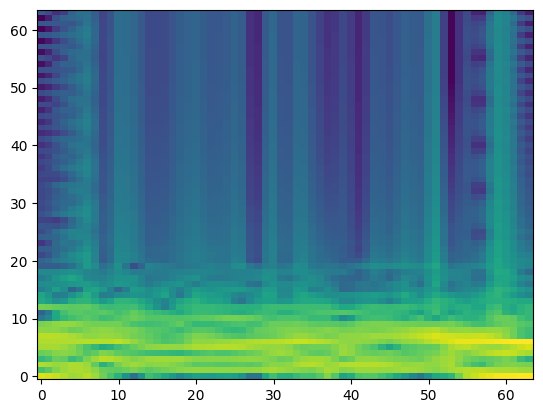

In [3]:
x = eegdataset.__getitem__(0)[0].numpy()
t = np.linspace(0, 5, 512)

_ = plt.imshow(x.squeeze()[11], aspect="auto", origin="lower")

In [4]:
import timm

In [5]:
timm.version

<module 'timm.version' from '/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/timm/version.py'>

In [6]:
torch.manual_seed(42)
device = torch.device('cuda')
batch_size = 16
accum_iter = 1
blr = 1e-3
weight_decay = 0.05
epochs = 100

eff_batch_size = batch_size * accum_iter
lr = blr * eff_batch_size / 256

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(accum_iter=1, mask_ratio=0.8, batch_size=batch_size, lr = blr, warmup_epochs=40, min_lr=0., epochs=epochs)

In [8]:
# DatasetLoader

data_loader_train = torch.utils.data.DataLoader(
        eegdataset, sampler=None,
        batch_size=batch_size,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
    )

In [9]:
mask_2d=False
mask_t_prob=0.5
mask_f_prob=0.3
audio_exp=True

maeeeg = models_mae.maeeg_vit_base_patch4_dec512d8b( in_chans = in_chans, img_size= spec_size, mask_2d=mask_2d,
                                                     mask_t_prob=mask_t_prob, mask_f_prob=mask_f_prob,audio_exp=audio_exp )

maeeeg.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed):

In [10]:
model_without_ddp = maeeeg
print("Model = %s" % str(model_without_ddp))

print("base lr: %.2e" % (lr * 256 / eff_batch_size))
print("actual lr: %.2e" % lr)

print("accumulate grad iterations: %d" % accum_iter)
print("effective batch size: %d" % eff_batch_size)


param_groups = optim_factory.add_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder

In [14]:
maeeeg.decoder_mode

0

In [11]:
maeeeg.to(device)
print(f"Start training for {epochs} epochs")
start_time = time.time()
for epoch in range(0, epochs):
    train_stats = train_one_epoch(
        maeeeg, data_loader_train,
        optimizer, device, epoch, loss_scaler,
        log_writer=None,
        args=args
    )
    # if args.output_dir and (epoch % args.save_every_epoch == 0 or epoch + 1 == args.epochs):
    #     misc.save_model(
    #         args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
    #         loss_scaler=loss_scaler, epoch=epoch)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,}

    # if args.output_dir and misc.is_main_process():
    #     if log_writer is not None:
    #         log_writer.flush()
    #     with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
    #         f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))


Start training for 100 epochs
Epoch: [0]  [  0/747]  eta: 0:24:27  lr: 0.000000  loss: 1032.1836 (1032.1836)  time: 1.9641  data: 0.9803  max mem: 2205
Epoch: [0]  [200/747]  eta: 0:00:44  lr: 0.000007  loss: 1114.9192 (1001.7665)  time: 0.0717  data: 0.0002  max mem: 2775


KeyboardInterrupt: 

In [458]:
maeeeg.to('cpu')

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed):

In [459]:
x = eegdataset.__getitem__(0)[0]
x.shape

torch.Size([128, 64, 64])

In [460]:
loss, y, mask_, _ = maeeeg(x.unsqueeze(0), 0.7)
print(loss)

tensor(9.8449, grad_fn=<DivBackward0>)


In [462]:
!pip list timm

Package                  Version
------------------------ ------------
absl-py                  2.0.0
aiohttp                  3.8.6
aiosignal                1.3.1
antlr4-python3-runtime   4.8
asttokens                2.4.1
async-timeout            4.0.3
attrs                    23.1.0
audioread                3.0.1
backcall                 0.2.0
cachetools               5.3.2
certifi                  2023.7.22
cffi                     1.16.0
charset-normalizer       3.3.1
click                    8.1.7
cloudpickle              3.0.0
comm                     0.1.4
contourpy                1.1.1
cycler                   0.12.1
debugpy                  1.6.7
decorator                5.1.1
defusedxml               0.7.1
docker-pycreds           0.4.0
einops                   0.3.0
entrypoints              0.4
executing                2.0.1
filelock                 3.12.4
fonttools                4.43.1
frozenlist               1.4.0
fsspec                   2023.10.0
gitdb                

In [452]:
maeeeg.forward_encoder(x.unsqueeze(0), 0.7)[0].shape

torch.Size([1, 77, 768])

In [456]:
(77*768)/512

115.5

In [440]:
y = unpatchify(y, 128)
y = torch.einsum('nchw->nhwc', y).detach().cpu().squeeze()

In [441]:
y.shape

torch.Size([64, 64, 128])

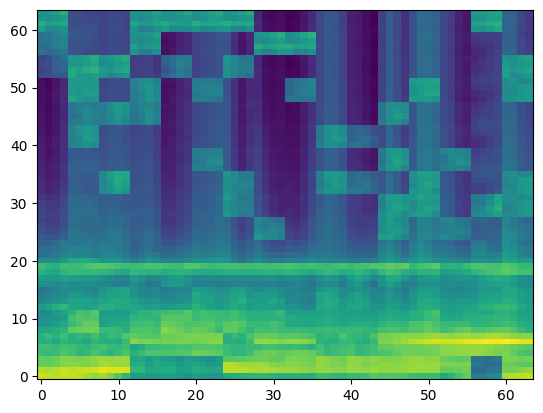

In [442]:

plt.imshow(y[:,:,100], aspect="auto", origin="lower")

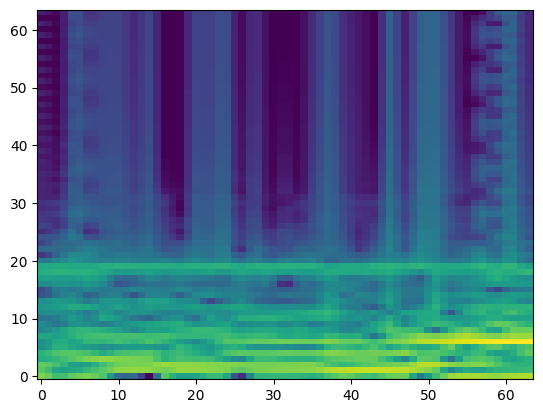

In [443]:
plt.imshow(x[100], aspect="auto", origin="lower")

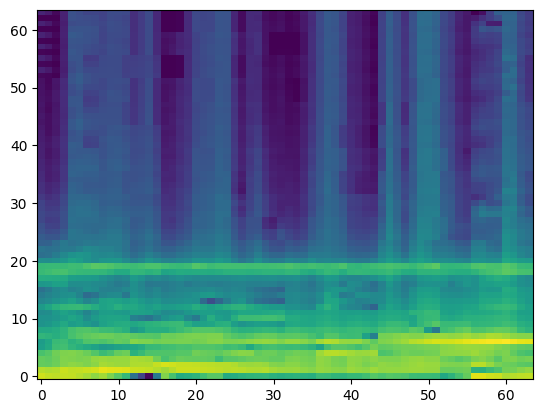

In [448]:
plt.imshow(im_paste.squeeze()[:,:,100], aspect="auto", origin="lower")

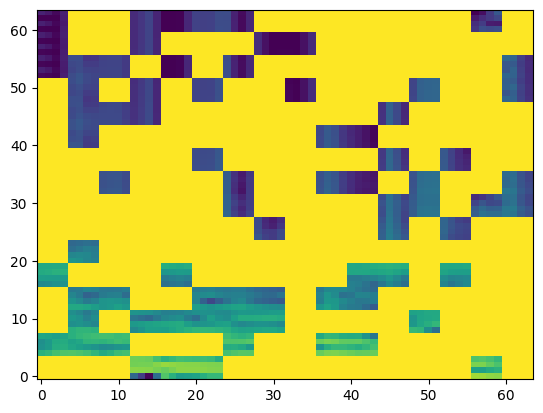

In [446]:
plt.imshow(im_masked.squeeze()[:,:,100], aspect="auto", origin="lower")

In [445]:
mask = mask_.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, maeeeg.patch_embed.patch_size[0]**2 *128)
print(mask.shape)
mask = unpatchify(mask,128)  # 0 is keep, 1 is remove
print(mask.shape)
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
print(mask.shape)

x_ = torch.einsum('nchw->nhwc', x.unsqueeze(0))
print('x',x.shape)
# masked image
im_masked = x_ * ( 1 - mask) 

im_paste = x_ * (1 - mask) + y * mask

im_masked2 = im_masked + (1 - mask)*-53

torch.Size([1, 256, 2048])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 64, 128])
x torch.Size([128, 64, 64])


In [185]:
def unpatchify(x, c=1):
    """
    x: (N, L, patch_size**2 *3)
    specs: (N, 1, H, W)
    """
    p = 4 
    h = 64//p
    w = 64//p
    x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
    x = torch.einsum('nhwpqc->nchpwq', x)
    specs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
    return specs